# Домашнее задание по теме "Оценка точности модели, переобучение, регуляризация"

- Дана статистика пользователей adult.csv.
- Получите значения AUC для различных моделей и их параметров.
- Используйте как минимум 3 различные модели классификации.
- Решением будет ссылка на гитхаб с ноутбуком.

In [31]:
import numpy as np
import random
import pylab
from scipy import stats
import pylab as pl
import mpl_toolkits
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score


import pandas as pd
from sklearn.datasets import make_blobs
import plotly.express as px
import seaborn as sns
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
# import plotly as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [32]:
# Загружаем датасет 
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [33]:
# используем отличную библиотеку для более глубокого анализа 
# много полезной инфы можно получить ничего не делая руками
data.profile_report()

# Feature Engineering

In [34]:
# fnlwgt
data = data.drop(['fnlwgt'], axis=1)
data.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [35]:
# is male
data['is_male'] = (data['gender'] == 'Male').astype(int)
data.drop(columns = ['gender'], inplace= True)
data.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,income,is_male
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States,<=50K,1
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States,<=50K,1
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,>50K,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States,>50K,1
4,18,?,Some-college,10,Never-married,?,Own-child,White,0,0,30,United-States,<=50K,0


In [36]:
# relationship
data['with_relationship'] = ((data['relationship'] == 'Husband') | (data['relationship'] == 'Wife')).astype(int)
data.drop(columns = ['relationship'], inplace= True)
data.head()

,age,workclass,education,educational-num,marital-status,occupation,race,capital-gain,capital-loss,hours-per-week,native-country,income,is_male,with_relationship
0,25,Private,11th,7,Never-married,Machine-op-inspct,Black,0,0,40,United-States,<=50K,1,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,White,0,0,50,United-States,<=50K,1,1
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,White,0,0,40,United-States,>50K,1,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Black,7688,0,40,United-States,>50K,1,1
4,18,?,Some-college,10,Never-married,?,White,0,0,30,United-States,<=50K,0,0


In [37]:
# marital-status
data.drop(columns = ['marital-status'], inplace= True)
data.head()

,age,workclass,education,educational-num,occupation,race,capital-gain,capital-loss,hours-per-week,native-country,income,is_male,with_relationship
0,25,Private,11th,7,Machine-op-inspct,Black,0,0,40,United-States,<=50K,1,0
1,38,Private,HS-grad,9,Farming-fishing,White,0,0,50,United-States,<=50K,1,1
2,28,Local-gov,Assoc-acdm,12,Protective-serv,White,0,0,40,United-States,>50K,1,1
3,44,Private,Some-college,10,Machine-op-inspct,Black,7688,0,40,United-States,>50K,1,1
4,18,?,Some-college,10,?,White,0,0,30,United-States,<=50K,0,0


In [38]:
# education
data.drop(columns = ['education'], inplace= True)
data.head()

,age,workclass,educational-num,occupation,race,capital-gain,capital-loss,hours-per-week,native-country,income,is_male,with_relationship
0,25,Private,7,Machine-op-inspct,Black,0,0,40,United-States,<=50K,1,0
1,38,Private,9,Farming-fishing,White,0,0,50,United-States,<=50K,1,1
2,28,Local-gov,12,Protective-serv,White,0,0,40,United-States,>50K,1,1
3,44,Private,10,Machine-op-inspct,Black,7688,0,40,United-States,>50K,1,1
4,18,?,10,?,White,0,0,30,United-States,<=50K,0,0


In [39]:
# occupation
data['high_level_occupation'] = ((data['occupation'] == 'Prof-specialty') | 
                               (data['occupation'] == 'Exec-managerial')).astype(int)

data['low_level_occupation'] = ((data['occupation'] == 'Other-service') | 
                              (data['occupation'] == 'Handlers-cleaners') |
                              (data['occupation'] == 'Priv-house-serv') |
                              (data['occupation'] == '?') |
                              (data['occupation'] == 'Machine-op-inspct')).astype(int)

data.drop(columns = ['occupation'], inplace= True)
data.head()

,age,workclass,educational-num,race,capital-gain,capital-loss,hours-per-week,native-country,income,is_male,with_relationship,high_level_occupation,low_level_occupation
0,25,Private,7,Black,0,0,40,United-States,<=50K,1,0,0,1
1,38,Private,9,White,0,0,50,United-States,<=50K,1,1,0,0
2,28,Local-gov,12,White,0,0,40,United-States,>50K,1,1,0,0
3,44,Private,10,Black,7688,0,40,United-States,>50K,1,1,0,1
4,18,?,10,White,0,0,30,United-States,<=50K,0,0,0,1


In [40]:
# native-country
data.drop(columns = ['native-country'], inplace= True)
data.head()

,age,workclass,educational-num,race,capital-gain,capital-loss,hours-per-week,income,is_male,with_relationship,high_level_occupation,low_level_occupation
0,25,Private,7,Black,0,0,40,<=50K,1,0,0,1
1,38,Private,9,White,0,0,50,<=50K,1,1,0,0
2,28,Local-gov,12,White,0,0,40,>50K,1,1,0,0
3,44,Private,10,Black,7688,0,40,>50K,1,1,0,1
4,18,?,10,White,0,0,30,<=50K,0,0,0,1


In [41]:
# workclass
data['is_self_empl'] = (data['workclass'] == 'Self-emp-inc').astype(int)
data.drop(columns = ['workclass'], inplace= True)
data.head()

,age,educational-num,race,capital-gain,capital-loss,hours-per-week,income,is_male,with_relationship,high_level_occupation,low_level_occupation,is_self_empl
0,25,7,Black,0,0,40,<=50K,1,0,0,1,0
1,38,9,White,0,0,50,<=50K,1,1,0,0,0
2,28,12,White,0,0,40,>50K,1,1,0,0,0
3,44,10,Black,7688,0,40,>50K,1,1,0,1,0
4,18,10,White,0,0,30,<=50K,0,0,0,1,0


In [42]:
# income
data['high_income'] = (data['income'] == '>50K').astype(int)
data.drop(columns = ['income'], inplace= True)
data.head()

,age,educational-num,race,capital-gain,capital-loss,hours-per-week,is_male,with_relationship,high_level_occupation,low_level_occupation,is_self_empl,high_income
0,25,7,Black,0,0,40,1,0,0,1,0,0
1,38,9,White,0,0,50,1,1,0,0,0,0
2,28,12,White,0,0,40,1,1,0,0,0,1
3,44,10,Black,7688,0,40,1,1,0,1,0,1
4,18,10,White,0,0,30,0,0,0,1,0,0


In [43]:
# race
data['is_race'] = (data['race'] == 'White').astype(int)
data.drop(columns = ['race'], inplace= True)
data.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,is_male,with_relationship,high_level_occupation,low_level_occupation,is_self_empl,high_income,is_race
0,25,7,0,0,40,1,0,0,1,0,0,0
1,38,9,0,0,50,1,1,0,0,0,0,1
2,28,12,0,0,40,1,1,0,0,0,1,1
3,44,10,7688,0,40,1,1,0,1,0,1,0
4,18,10,0,0,30,0,0,0,1,0,0,1


# Modeling

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['high_income']),  
                                                    data[['high_income']], 
                                                    test_size = 0.2)

In [45]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
from sklearn.metrics import roc_curve
def print_roc_curve(y_test, pred):
    fpr, tpr, thres = roc_curve(y_test, pred[:,0])
    plt.plot(tpr,fpr)

[[7083  402]
 [ 986 1298]]
0.8579179035725253


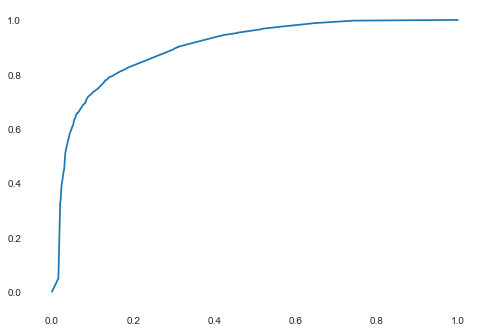

In [47]:
clf = DecisionTreeClassifier(max_depth=10, random_state = 0)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test)))
print(accuracy_score(y_test, clf.predict(X_test)))
print_roc_curve(y_test, clf.predict_proba(X_test))

In [48]:
clf.feature_importances_

array([0.04624373, 0.21072311, 0.19467314, 0.07438994, 0.03328558,
       0.00478493, 0.39832926, 0.02864761, 0.00680811, 0.0011556 ,
       0.000959  ])

0.8715737209837996
0.8623195823523391


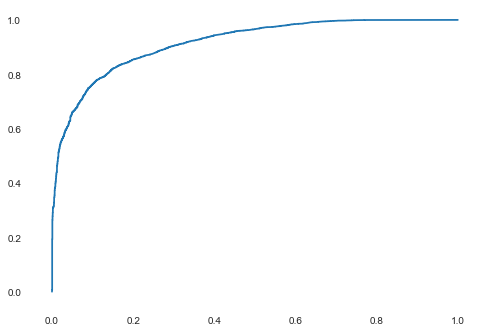

In [49]:
r = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state = 10)),

    ],
LogisticRegression())

m = r.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_test, y_test))
print_roc_curve(y_test, m.predict_proba(X_test))

[[7126  359]
 [ 975 1309]]
0.8634455932029891


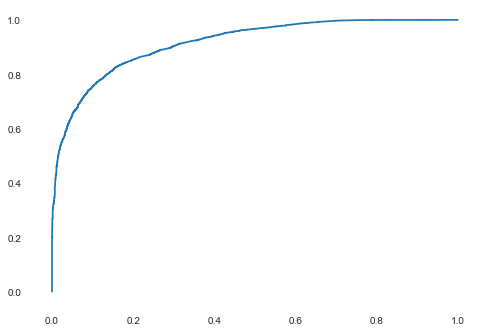

In [50]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state = 0)
rf.fit(X_train, y_train)

print(confusion_matrix(y_test, rf.predict(X_test)))
print(accuracy_score(y_test, rf.predict(X_test)))
print_roc_curve(y_test, rf.predict_proba(X_test))

[[6972  513]
 [ 980 1304]]
0.847169618179957


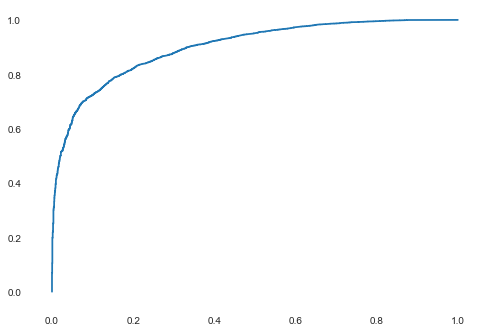

In [51]:
lr= LogisticRegression()
lr.fit(X_train, y_train)

print(confusion_matrix(y_test, lr.predict(X_test)))
print(accuracy_score(y_test, lr.predict(X_test)))
print_roc_curve(y_test, lr.predict_proba(X_test))